In [238]:
"""
https://www.youtube.com/watch?v=6f67zrH-_IE
https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/23_Time-Series-Prediction.ipynb
"""
__author__ = "Casper Kristiansson"
__copyright__ = "WeatherBrain"

__maintainer__ = "Casper Kristiansson"
__email__ = "casperkr@kth.se"
__status__ = "Development"

In [239]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

In [240]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

In [241]:
df = pd.read_csv('..\\Data\\Processed Data\\smhi_data.csv',low_memory=False)
df.head()

,Date,Temperature,Air Pressure,Humidity
0,1996-10-01 00:00:00,10.5,996.2,80
1,1996-10-01 03:00:00,10.1,995.9,82
2,1996-10-01 06:00:00,10.2,995.3,81
3,1996-10-01 09:00:00,11.9,995.8,75
4,1996-10-01 12:00:00,13.0,995.5,70


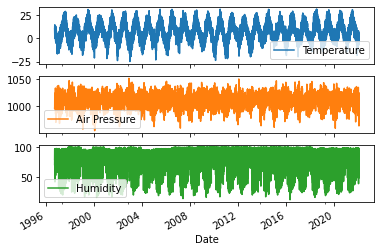

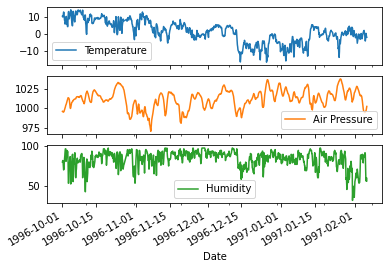

In [242]:
date_time = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S')

plot_cols = ['Temperature', 'Air Pressure', 'Humidity']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:1000]
plot_features.index = date_time[:1000]
_ = plot_features.plot(subplots=True)

(-24.7, 31.4, 954.9, 1051.6)

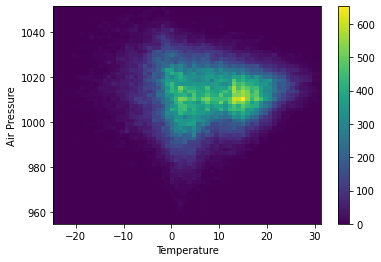

In [243]:
plt.hist2d(df['Temperature'], df['Air Pressure'], bins=(60, 60))
plt.colorbar()
plt.xlabel('Temperature')
plt.ylabel('Air Pressure')
ax = plt.gca()
ax.axis('tight')

(-24.7, 31.4, 12.0, 100.0)

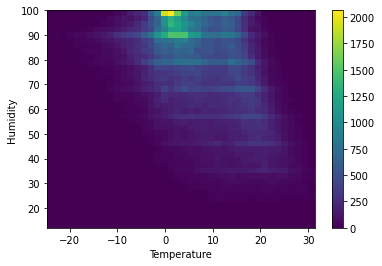

In [244]:
plt.hist2d(df['Temperature'], df['Humidity'], bins=(40, 40))
plt.colorbar()
plt.xlabel('Temperature')
plt.ylabel('Humidity')
ax = plt.gca()
ax.axis('tight')

(954.9, 1051.6, 12.0, 100.0)

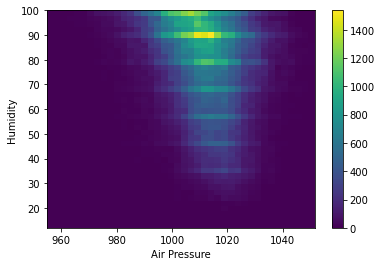

In [245]:
plt.hist2d(df['Air Pressure'], df['Humidity'], bins=(40, 40))
plt.colorbar()
plt.xlabel('Air Pressure')
plt.ylabel('Humidity')
ax = plt.gca()
ax.axis('tight')

In [246]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S')

In [247]:
df['Day'] = df['Date'].dt.day_of_year
df.head(10)

,Date,Temperature,Air Pressure,Humidity,Day
0,1996-10-01 00:00:00,10.5,996.2,80,275
1,1996-10-01 03:00:00,10.1,995.9,82,275
2,1996-10-01 06:00:00,10.2,995.3,81,275
3,1996-10-01 09:00:00,11.9,995.8,75,275
4,1996-10-01 12:00:00,13.0,995.5,70,275
5,1996-10-01 15:00:00,12.6,995.6,71,275
6,1996-10-01 21:00:00,8.1,998.0,84,275
7,1996-10-02 00:00:00,8.0,999.3,88,276
8,1996-10-02 03:00:00,5.9,1000.3,94,276
9,1996-10-02 06:00:00,6.7,1002.0,97,276


In [248]:
df['Hour'] = df['Date'].dt.hour
df.head()

,Date,Temperature,Air Pressure,Humidity,Day,Hour
0,1996-10-01 00:00:00,10.5,996.2,80,275,0
1,1996-10-01 03:00:00,10.1,995.9,82,275,3
2,1996-10-01 06:00:00,10.2,995.3,81,275,6
3,1996-10-01 09:00:00,11.9,995.8,75,275,9
4,1996-10-01 12:00:00,13.0,995.5,70,275,12


In [249]:
df.set_index('Date', inplace=True)

In [250]:
col = df.pop('Day')
df.insert(0, col.name, col)

In [251]:
df.head()

,Day,Temperature,Air Pressure,Humidity,Hour
Date,,,,,
1996-10-01 00:00:00,275,10.5,996.2,80,0
1996-10-01 03:00:00,275,10.1,995.9,82,3
1996-10-01 06:00:00,275,10.2,995.3,81,6
1996-10-01 09:00:00,275,11.9,995.8,75,9
1996-10-01 12:00:00,275,13.0,995.5,70,12


In [252]:
target_names = ['Temperature', 'Air Pressure', 'Humidity']

In [253]:
shift_days = 1
shift_steps = shift_days * 24  # Number of hours.

In [254]:
df_targets = df[target_names].shift(-shift_steps)

In [255]:
df[target_names].head(shift_steps + 5)

,Temperature,Air Pressure,Humidity
Date,,,
1996-10-01 00:00:00,10.5,996.2,80
1996-10-01 03:00:00,10.1,995.9,82
1996-10-01 06:00:00,10.2,995.3,81
1996-10-01 09:00:00,11.9,995.8,75
1996-10-01 12:00:00,13.0,995.5,70
1996-10-01 15:00:00,12.6,995.6,71
1996-10-01 21:00:00,8.1,998.0,84
1996-10-02 00:00:00,8.0,999.3,88
1996-10-02 03:00:00,5.9,1000.3,94


In [256]:
df_targets.head()

,Temperature,Air Pressure,Humidity
Date,,,
1996-10-01 00:00:00,10.9,1004.7,83.0
1996-10-01 03:00:00,11.6,1001.3,87.0
1996-10-01 06:00:00,12.5,999.9,80.0
1996-10-01 09:00:00,14.3,1001.2,52.0
1996-10-01 12:00:00,13.6,1003.5,54.0


In [257]:
df_targets.tail()

,Temperature,Air Pressure,Humidity
Date,,,
2022-02-01 01:00:00,NaN,NaN,NaN
2022-02-01 02:00:00,NaN,NaN,NaN
2022-02-01 03:00:00,NaN,NaN,NaN
2022-02-01 04:00:00,NaN,NaN,NaN
2022-02-01 05:00:00,NaN,NaN,NaN


In [258]:
x_data = df.values[:-shift_steps]

In [259]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (213226, 5)


In [260]:
y_data = df_targets.values[:-shift_steps]

In [261]:
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (213226, 3)


In [262]:
num_data = len(x_data)
num_data

213226

In [263]:
train_split = 0.9

In [264]:
num_train = int(train_split * num_data)
num_train

191903

In [265]:
num_test = num_data - num_train
num_test

21323

In [266]:
x_train = x_data[:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

213226

In [267]:
y_train = y_data[:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

213226

In [268]:
num_x_signals = x_data.shape[1]
num_x_signals

5

In [269]:
num_y_signals = y_data.shape[1]
num_y_signals

3

In [270]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: -24.7
Max: 1051.6


In [271]:
x_scaler = MinMaxScaler()

In [272]:
x_train_scaled = x_scaler.fit_transform(x_train)

In [273]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


In [274]:
x_test_scaled = x_scaler.transform(x_test)

In [275]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [276]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(191903, 5)
(191903, 3)


In [277]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [278]:
batch_size = 128

In [279]:
sequence_length = 24 * 7 * 8
sequence_length

1344

In [280]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [281]:
x_batch, y_batch = next(generator)

In [282]:
print(x_batch.shape)
print(y_batch.shape)

(128, 1344, 5)
(128, 1344, 3)


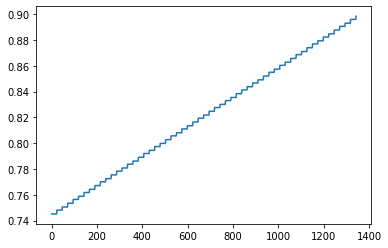

In [283]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

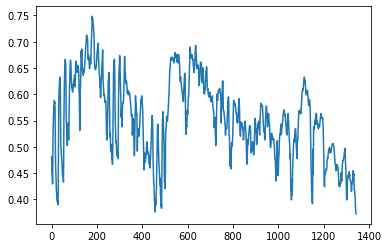

In [284]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

In [285]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [286]:
model = Sequential()

In [287]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

In [288]:
model.add(Dense(num_y_signals, activation='sigmoid'))

In [289]:
warmup_steps = 50

In [290]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [291]:
optimizer = RMSprop(lr=1e-3)

c:\Users\caspe\OneDrive\Documents\Universitet\Year 2\II1302 Projects and Project Methods\Weather-Predictor\Backend\Machine Learning\venv\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [292]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [293]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, None, 512)         797184    
                                                                 
 dense_3 (Dense)             (None, None, 3)           1539      
                                                                 
Total params: 798,723
Trainable params: 798,723
Non-trainable params: 0
_________________________________________________________________


In [294]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [295]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [296]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [297]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [298]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

## Train the Recurrent Neural Network

We can now train the neural network.

Note that a single "epoch" does not correspond to a single processing of the training-set, because of how the batch-generator randomly selects sub-sequences from the training-set. Instead we have selected `steps_per_epoch` so that one "epoch" is processed in a few minutes.

With these settings, each "epoch" took about 2.5 minutes to process on a GTX 1070. After 14 "epochs" the optimization was stopped because the validation-loss had not decreased for 5 "epochs". This optimization took about 35 minutes to finish.

Also note that the loss sometimes becomes `NaN` (not-a-number). This is often resolved by restarting and running the Notebook again. But it may also be caused by your neural network architecture, learning-rate, batch-size, sequence-length, etc. in which case you may have to modify those settings.

In [299]:
model.fit(x=generator,
          epochs=20,
          steps_per_epoch=100,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.0163
Epoch 1: val_loss improved from inf to 0.01385, saving model to 23_checkpoint.keras
100/100 [==============================] - 35s 340ms/step - loss: 0.0163 - val_loss: 0.0139 - lr: 0.0010
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.0123
Epoch 2: val_loss improved from 0.01385 to 0.01221, saving model to 23_checkpoint.keras
100/100 [==============================] - 34s 338ms/step - loss: 0.0123 - val_loss: 0.0122 - lr: 0.0010
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.0113
Epoch 3: val_loss improved from 0.01221 to 0.01102, saving model to 23_checkpoint.keras
100/100 [==============================] - 34s 338ms/step - loss: 0.0113 - val_loss: 0.0110 - lr: 0.0010
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss: 0.0108
Epoch 4: val_loss improved from 0.01102 to 0.01005, saving model to 23_checkpoint.keras
100/100 [====================

In [300]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [301]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 487ms/step - loss: 0.0085


In [302]:
print("loss (test-set):", result)

loss (test-set): 0.008483806625008583


In [303]:
# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

In [304]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

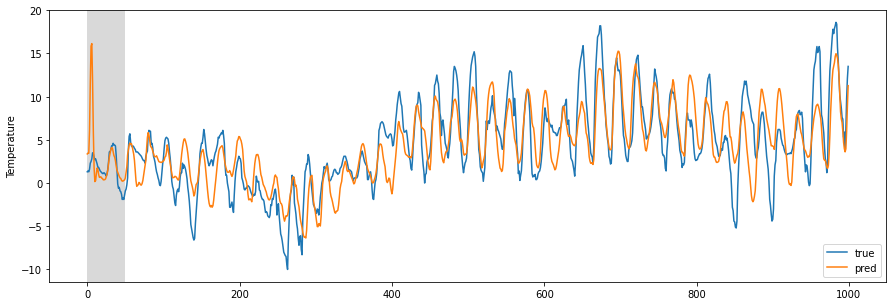

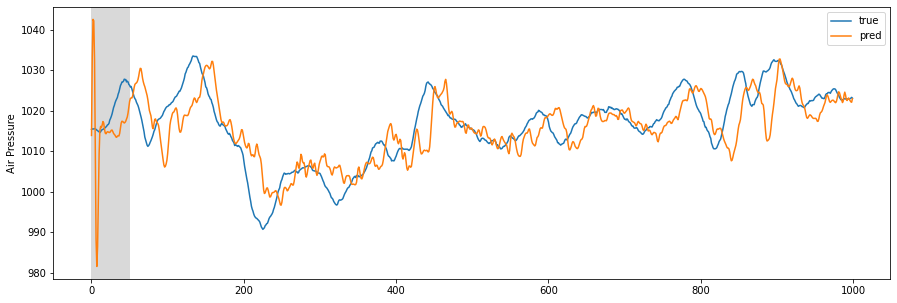

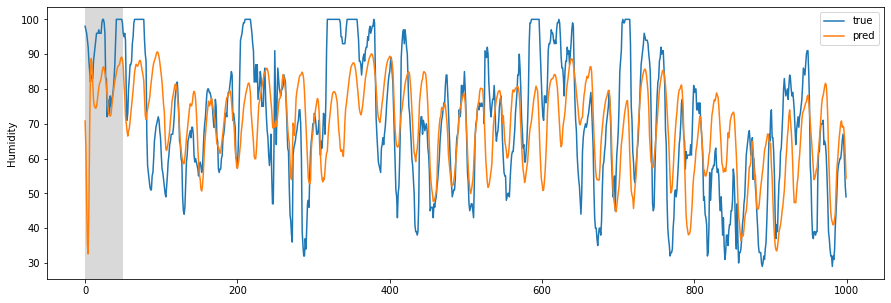

In [305]:
plot_comparison(start_idx=100000, length=1000, train=True)

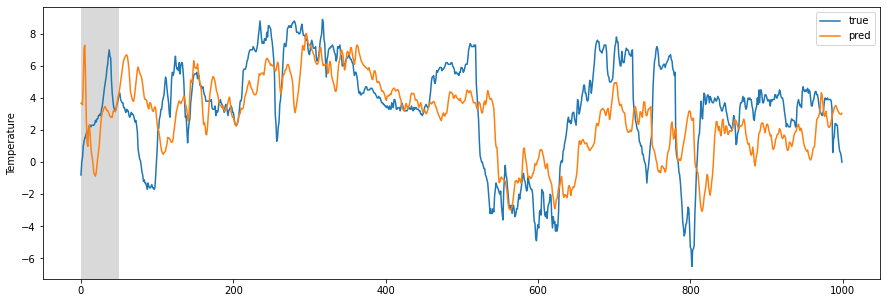

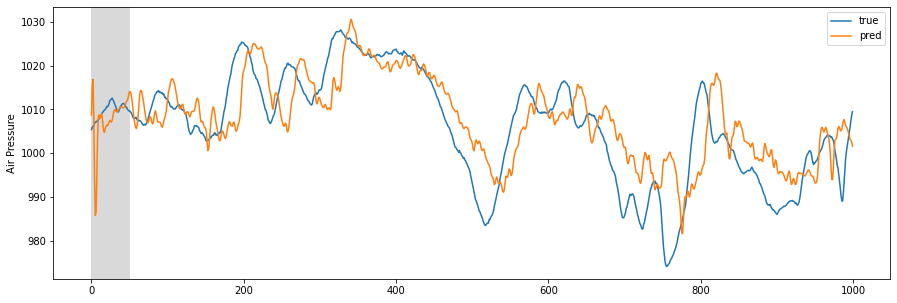

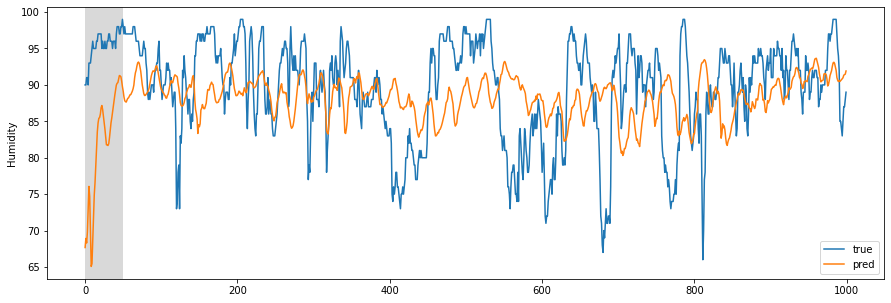

In [308]:
plot_comparison(start_idx=200, length=1000, train=False)

In [309]:
model.save('saved_model/weather_model')

INFO:tensorflow:Assets written to: saved_model/weather_model\assets


INFO:tensorflow:Assets written to: saved_model/weather_model\assets
